### Binary mixture phase diagrams using Flory-Huggins Free Energy


In [1]:
import numpy as np
DTYPE = np.float64 # Double precision
epsilon = np.finfo(DTYPE).eps

import numdifftools as nd

import matplotlib
import matplotlib.pyplot as plt

from tqdm import tqdm

from numba import njit

import warnings
warnings.filterwarnings("ignore")

In [2]:
def floryHuggins_2components(phi, nu, nA, nB, chi):
    res = (phi*np.log(phi)/nA) + ((1-phi)*np.log(1-phi)/nB) + chi*phi*(1-phi)
    return res/nu

In [3]:
def calculateBinodals(phis, nu, nA, nB, chis):
    df_dphis_chis = [] # values of delF/delphi for all phis and chis. Indexed by the value of chi 
    
    for chi in tqdm(chis):
        binodal_chi = [] # binodal points for this specific chi
        
        first_derivative = nd.Derivative(lambda phi: floryHuggins_2components(phi, nu, nA, nB, chi), n=1)
        df_dphis_chi = [] # values of delF/delphi for all phis for a particular chi
        
        for idx, phi in enumerate(phis):
            df_dphi_phi = first_derivative(phi) # value of delF/delphi for a particular phi for a particular chi
            df_dphis_chi.append(df_dphi_phi)    
    
        df_dphis_chis.append(df_dphis_chi)
        
    binodals = []
    for chi_idx, chi in enumerate(chis):
        binodals_chi = []
        for idx, df_dphi in enumerate(df_dphis_chis[chi_idx][:]):
            if np.sign(df_dphis_chis[chi_idx][idx]) == -1 and np.sign(df_dphis_chis[chi_idx][idx+1]) == 1:
                binodals_chi.append(phis[idx])
        binodals.append(binodals_chi)

    return binodals

def calculateSpinodals(phis, nu, nA, nB, chis):
    ddf_ddphis_chis = [] # values of ddelF/ddelphi for all phis and chis. Indexed by the value of chi 
    
    for chi in tqdm(chis):
        spinodal_chi = [] # spinodal points for this specific chi
        
        second_derivative = nd.Derivative(lambda phi: floryHuggins_2components(phi, nu, nA, nB, chi), n=2)
        ddf_ddphis_chi = [] # values of ddelF/ddelphi for all phis for a particular chi
        
        for idx, phi in enumerate(phis):
            ddf_ddphi_phi = second_derivative(phi) # value of ddelF/ddelphi for a particular phi for a particular chi
            ddf_ddphis_chi.append(ddf_ddphi_phi)    
    
        ddf_ddphis_chis.append(ddf_ddphis_chi)
    spinodals = []
    for chi_idx, chi in enumerate(chis):
        spinodals_chi = []
        for idx, ddf_ddphi in enumerate(ddf_ddphis_chis[chi_idx][:-1]):
            if (np.sign(ddf_ddphis_chis[chi_idx][idx]) == 1 and np.sign(ddf_ddphis_chis[chi_idx][idx+1]) == -1) or (np.sign(ddf_ddphis_chis[chi_idx][idx]) == -1 and np.sign(ddf_ddphis_chis[chi_idx][idx+1]) == 1):
                spinodals_chi.append(phis[idx])
                # print(idx, np.sign(df_dphis_chis[chi_idx][idx]), np.sign(df_dphis_chis[chi_idx][idx+1]), phis[idx])
        spinodals.append(spinodals_chi)
    
    return spinodals

In [4]:
# concentration of the first component
n_phis = 256
phis = np.linspace(epsilon, 1-epsilon, n_phis)

# Molecular parameters
nu = DTYPE(1)
nA = DTYPE(1)
nBs = [1, 1.3]

# Flory parameter
chis = np.linspace(epsilon, 3.5, 256, dtype = DTYPE)
# chis = [2.116]

In [5]:
ctr = 0
for nB in nBs:
    for chi in chis:
        fig, ax = plt.subplots()
        for phi in phis:
            ax.scatter(phi, floryHuggins_2components(phi, nu, nA, nB, chi), color = "k", s = 1)
            ax.set_xlabel(r"$\phi$")
            ax.set_ylabel(r"$F(\phi)$    (in $k_BT$)")
        title = f"$n_A$ : $n_B$ = {nA} : {nB}" + "\n" + f"$\\chi$={chi:.2f}"
        fig.suptitle(title)
        fig.tight_layout()
        fig.savefig(f"data/freeEnergy/{ctr}.png")
        plt.close()
        ctr+=1
        

In [6]:
ctr = 0
for nB in nBs:
    binodals = calculateBinodals(phis, nu, nA, nB, chis)
    spinodals = calculateSpinodals(phis, nu, nA, nB, chis)
    binodal_label_added = False
    spinodal_label_added = False
    
    fig, ax= plt.subplots()
    
    for idx, chi in enumerate(chis):
        for idx_binodal, critical_point in enumerate(binodals[idx]):
            ax.scatter(critical_point, chi, color = "k", s = 1,
                      label="Binodal" if not binodal_label_added else None)
            binodal_label_added = True
    
        for idx_spinodal, critical_point in enumerate(spinodals[idx]):
            ax.scatter(critical_point, chi, color = "r", s = 1,
                      label="Spinodal" if not spinodal_label_added else None)
            spinodal_label_added = True
            
    ax.legend(loc = "upper right")
    ax.set_xlabel(r"$\phi$")
    ax.set_ylabel(r"$\chi$")spinodal binodal phase separation binary mixture
    fig.suptitle(f"$n_A$ : $n_B$ = {nA} : {nB}")
    fig.tight_layout()
    fig.savefig(f"data/bin_spin/{ctr}.png")
    plt.close()
    ctr+=1

100%|█████████████████████████████████████████| 256/256 [00:29<00:00,  8.79it/s]


100%|███████████████████████████████████████████| 26/26 [00:15<00:00,  1.71it/s]


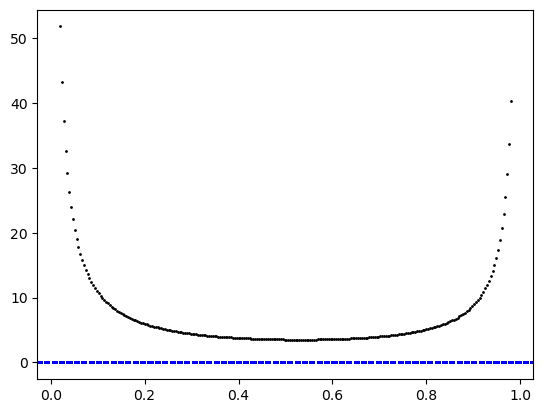

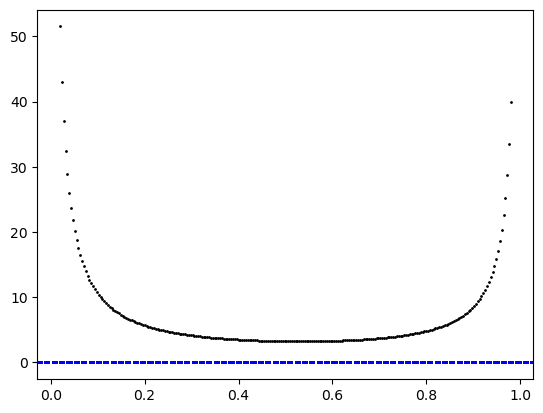

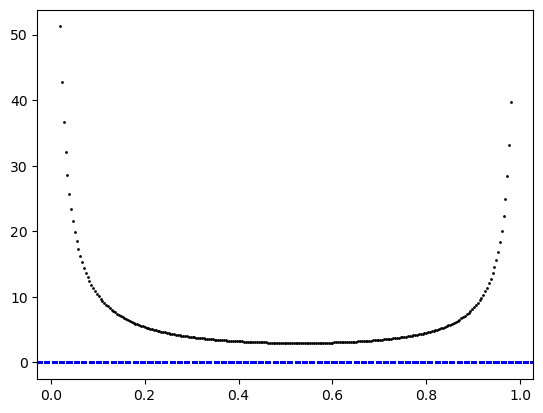

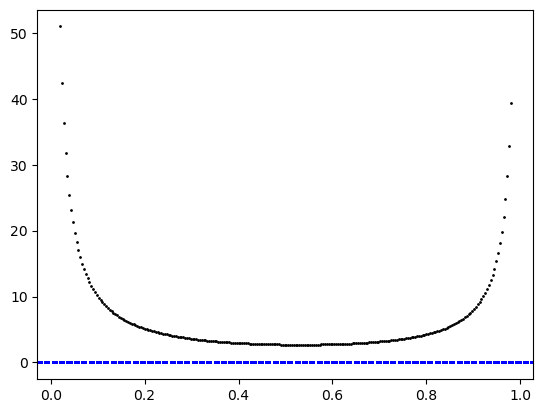

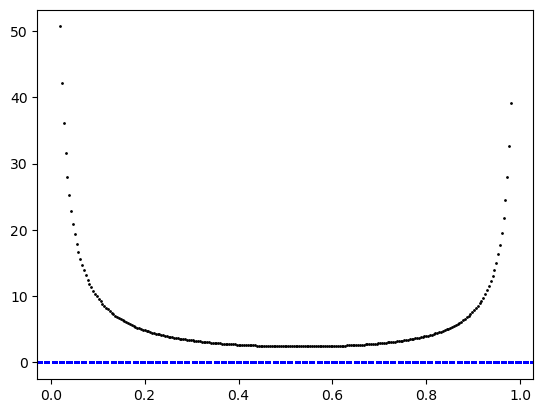

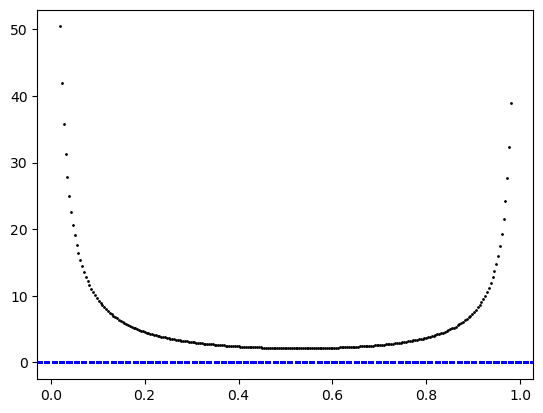

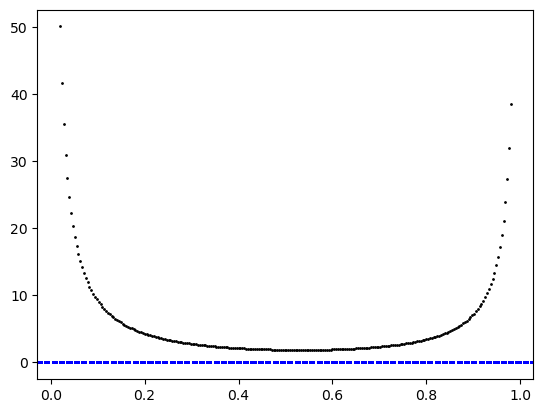

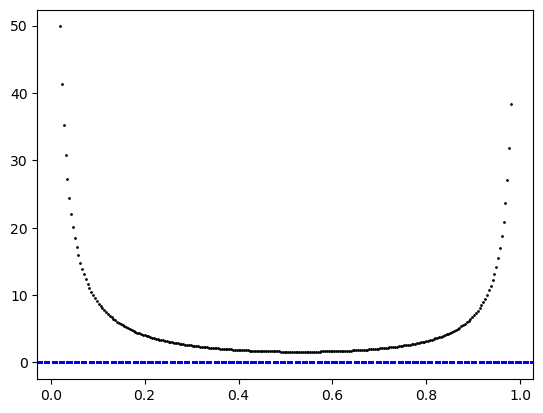

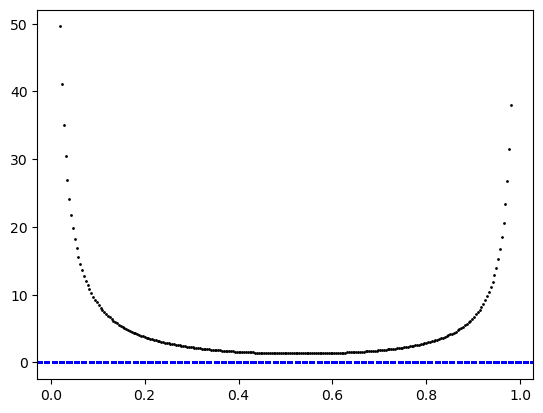

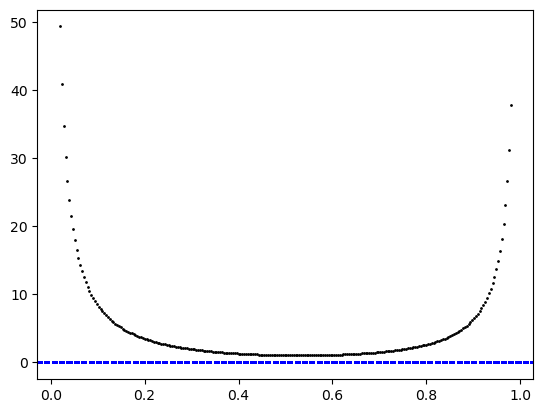

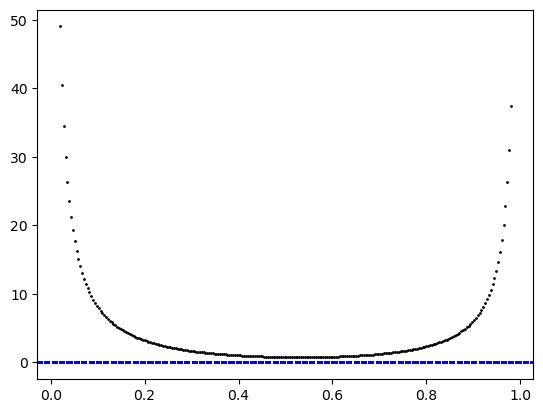

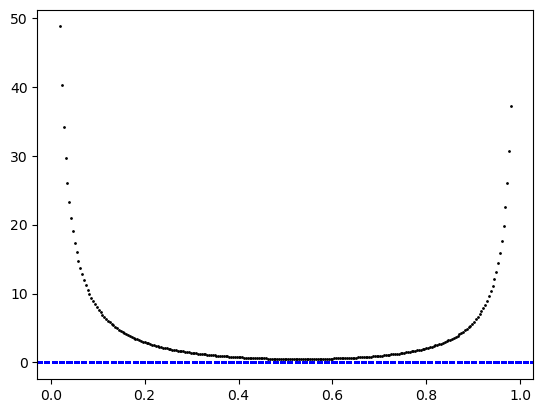

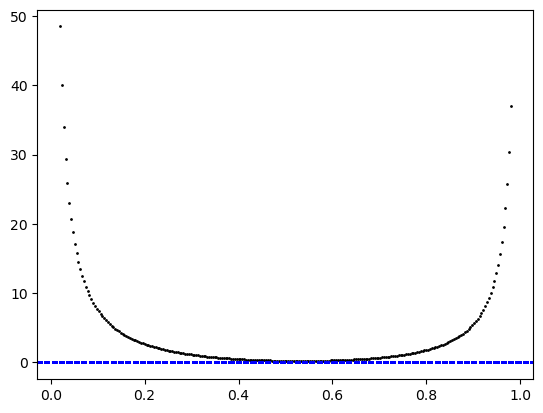

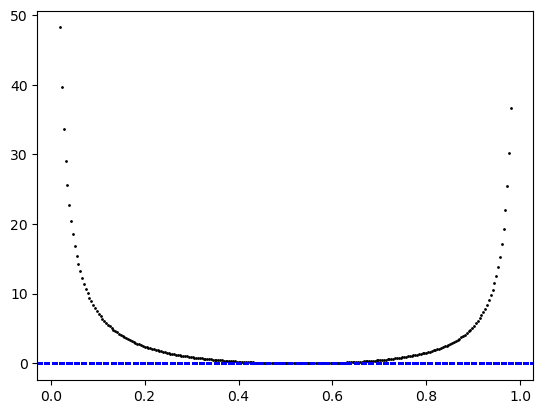

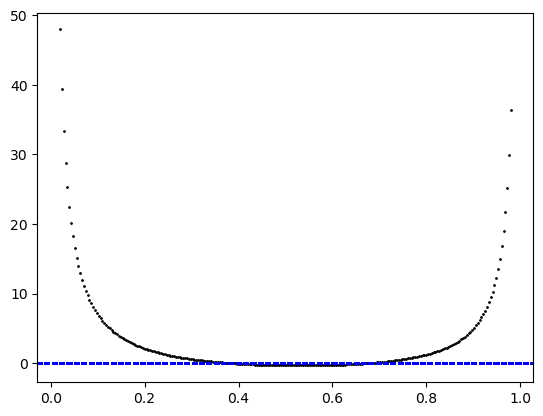

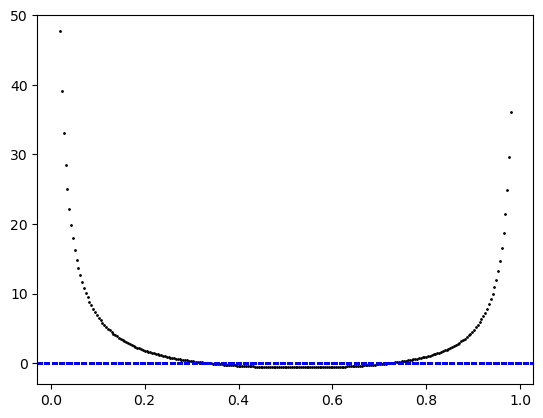

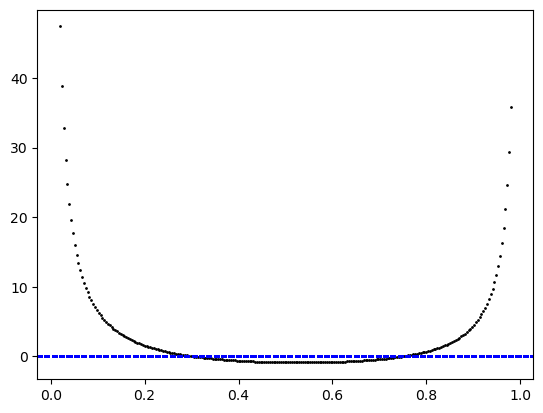

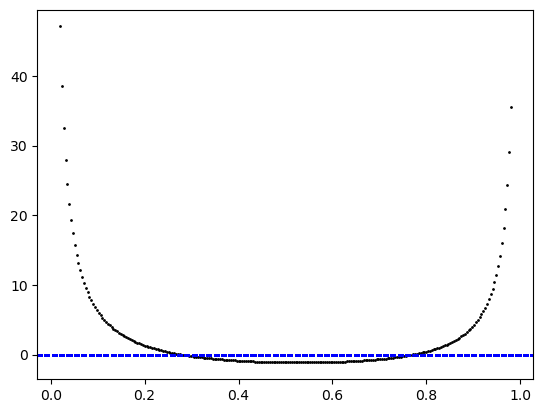

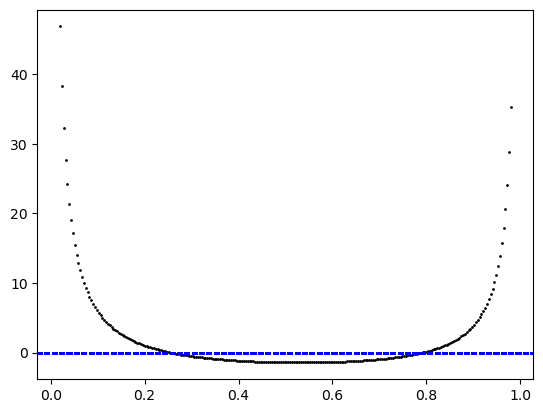

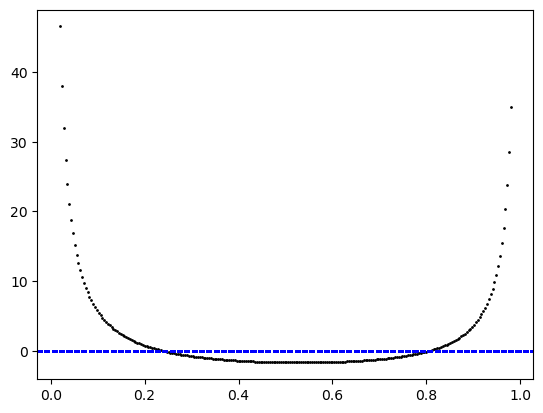

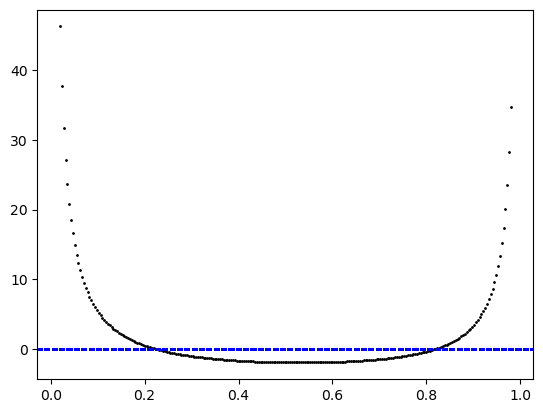

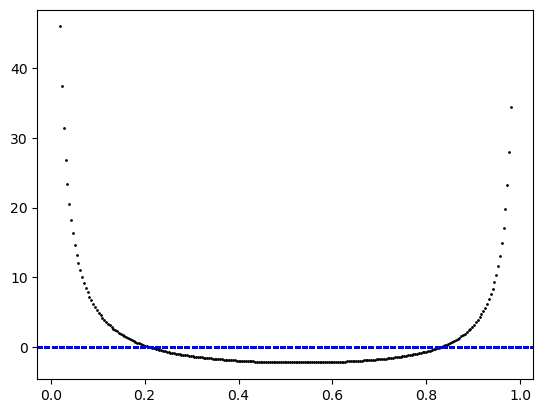

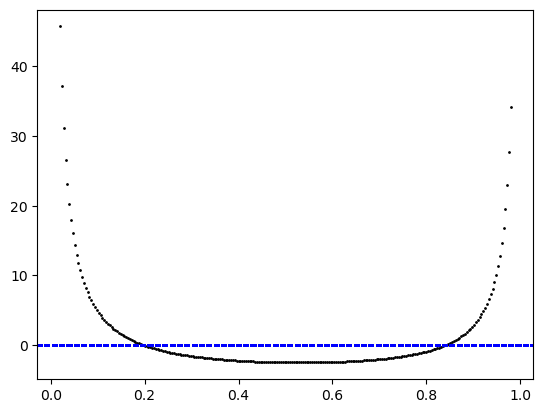

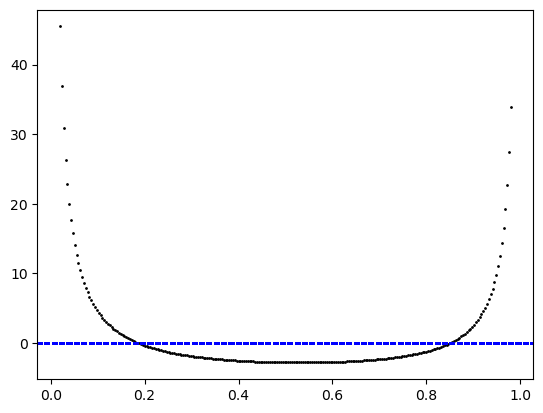

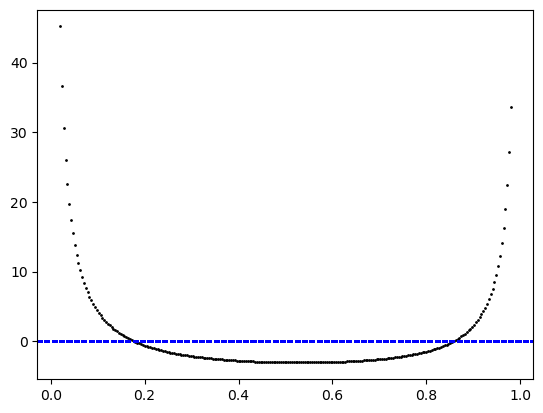

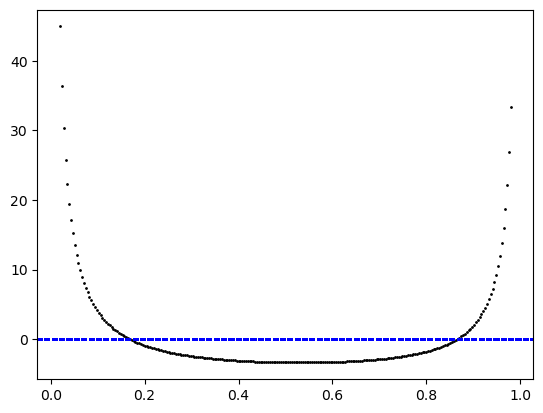

In [17]:
for chi in tqdm(chis[::10]):
    second_derivative = nd.Derivative(lambda phi: floryHuggins_2components(phi, nu, nA, nB, chi), n=2)
    ddf_ddphis_chi = [] # values of ddelF/ddelphi for all phis for a particular chi

    fig, ax = plt.subplots()
    
    for idx, phi in enumerate(phis):
        ddf_ddphi_phi = second_derivative(phi) # value of ddelF/ddelphi for a particular phi for a particular chi
        ddf_ddphis_chi.append(ddf_ddphi_phi)    
        ax.scatter(phi, ddf_ddphi_phi, color = "k", s = 1)
        ax.axhline(0, color = "blue", linestyle = "--", linewidth=1)

100%|███████████████████████████████████████████| 26/26 [00:14<00:00,  1.73it/s]


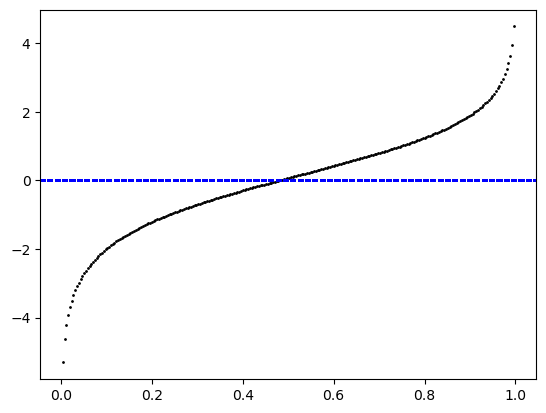

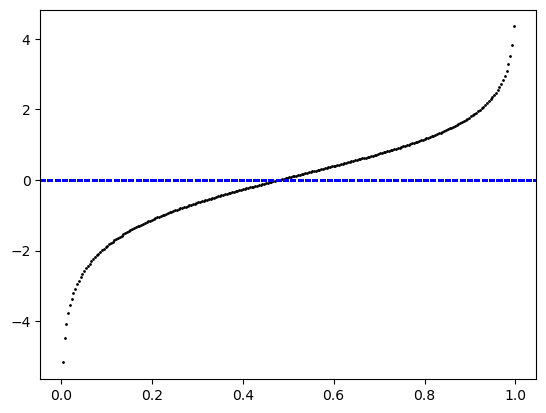

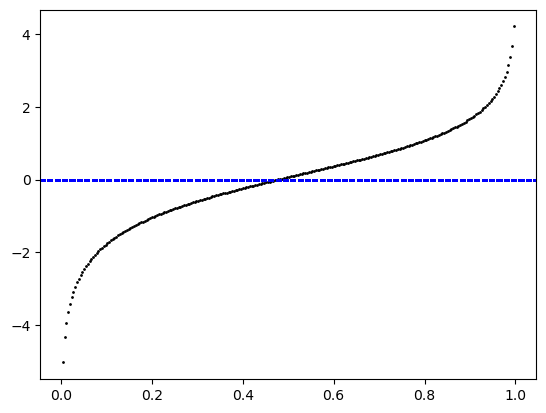

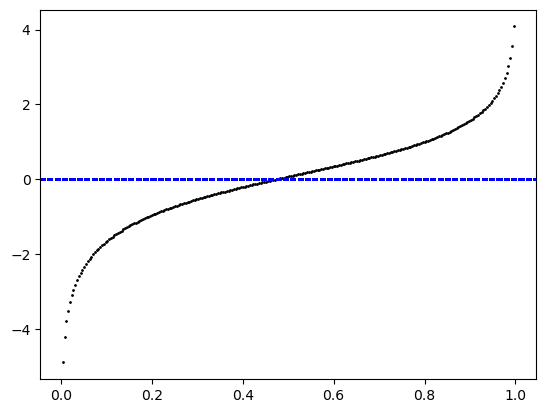

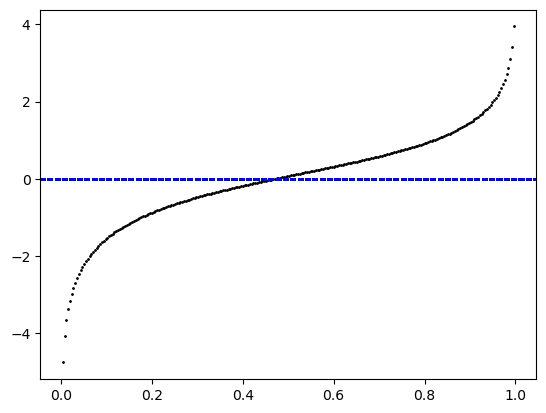

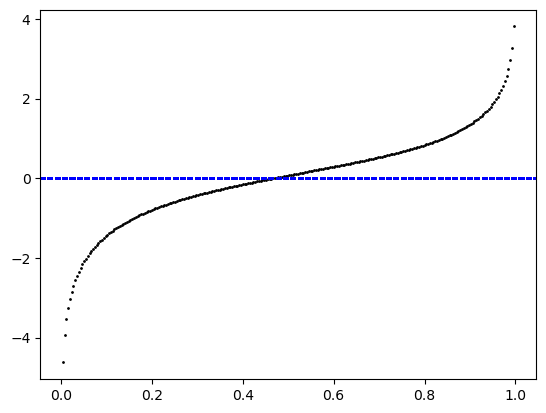

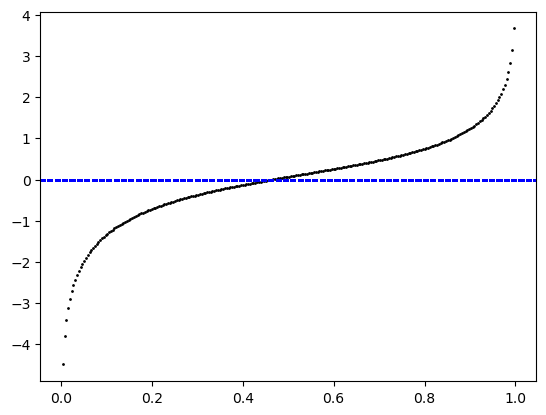

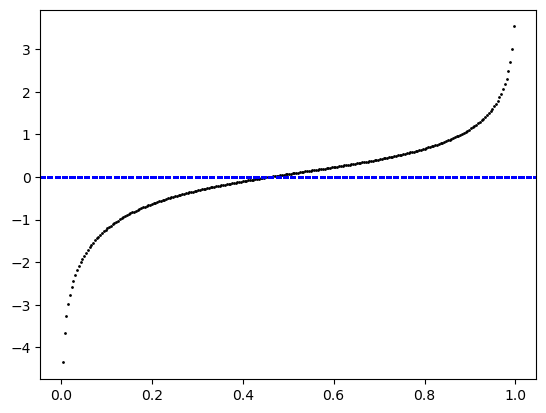

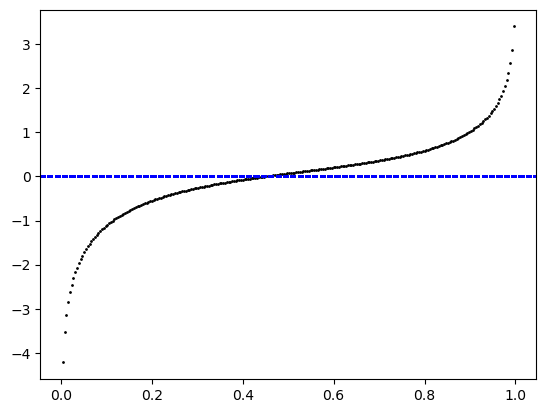

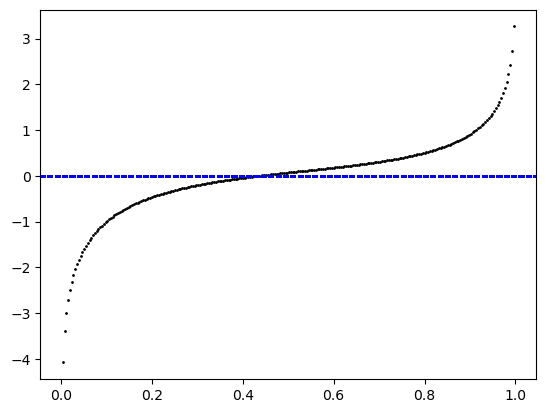

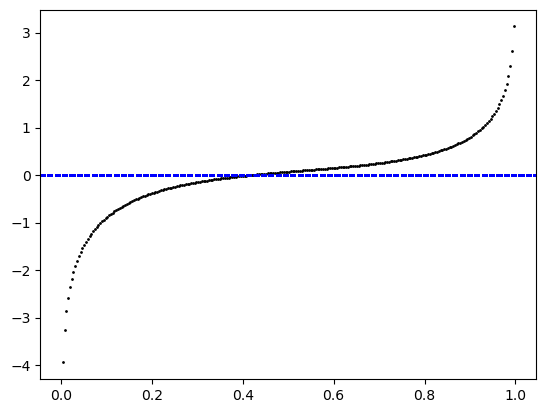

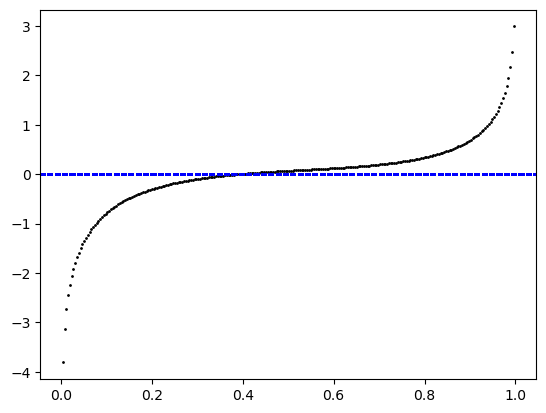

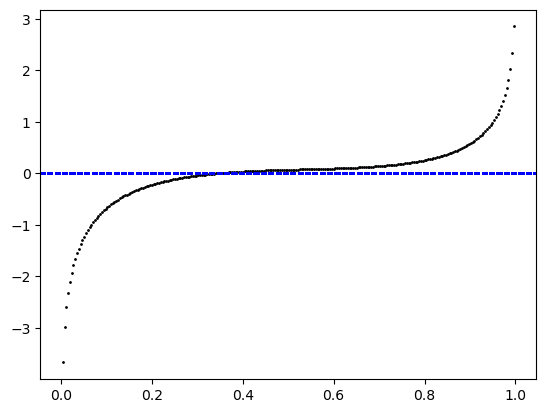

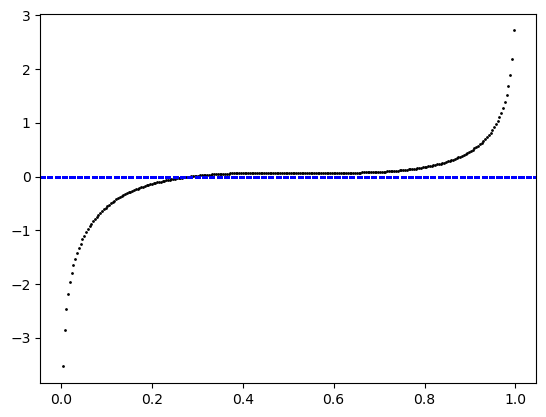

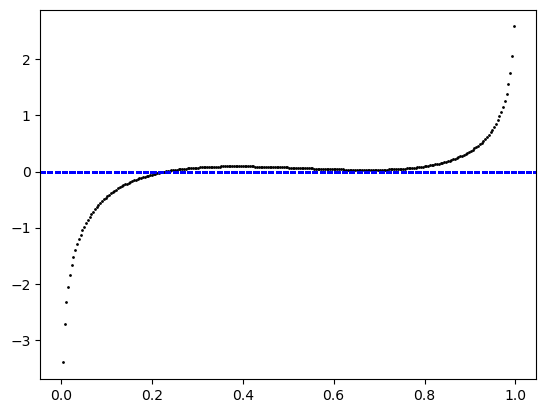

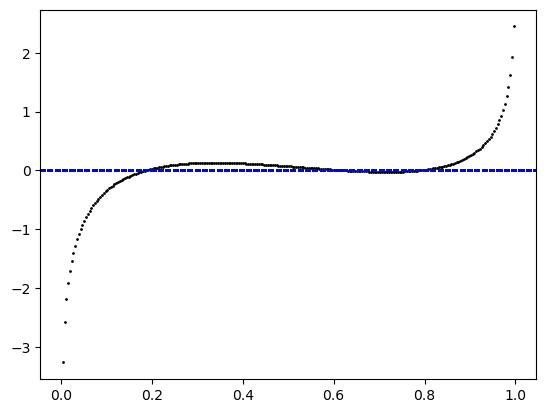

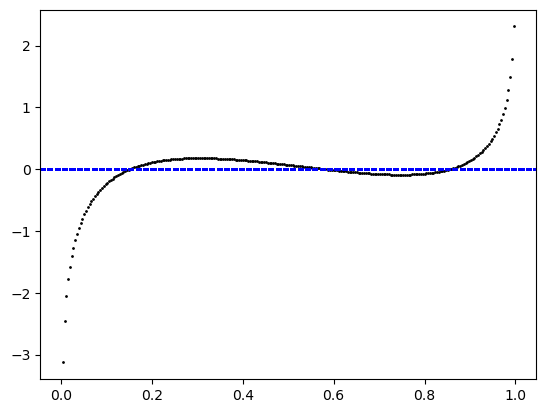

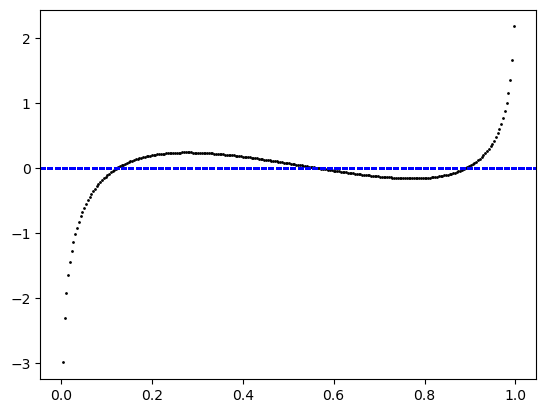

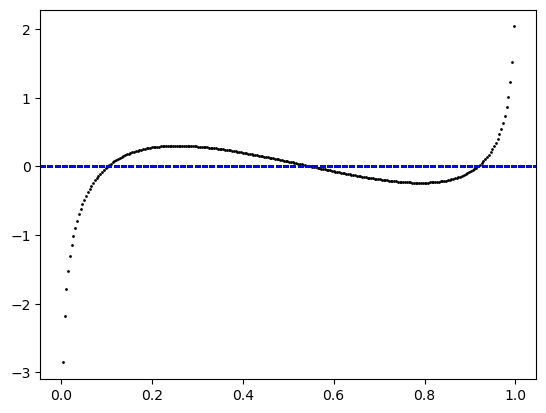

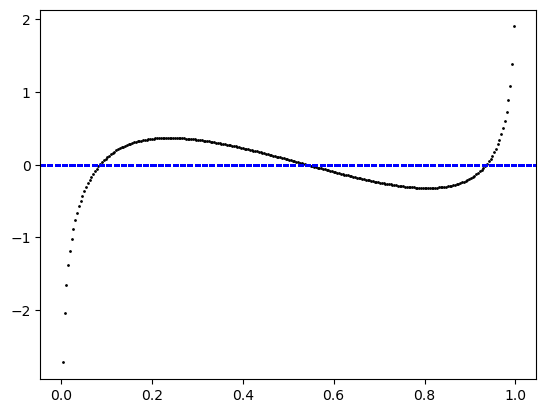

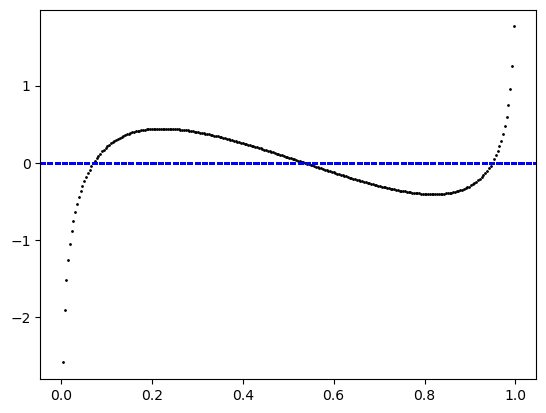

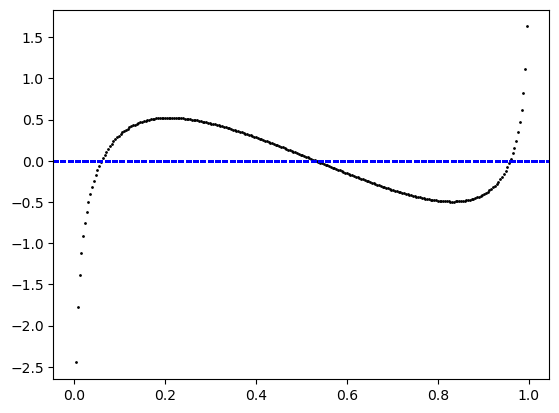

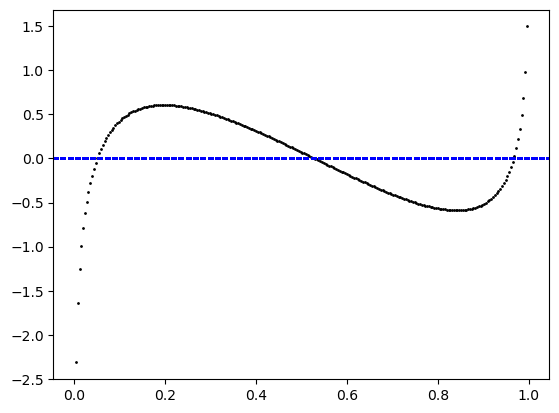

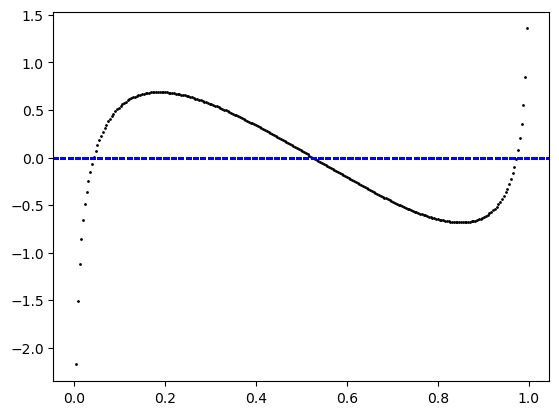

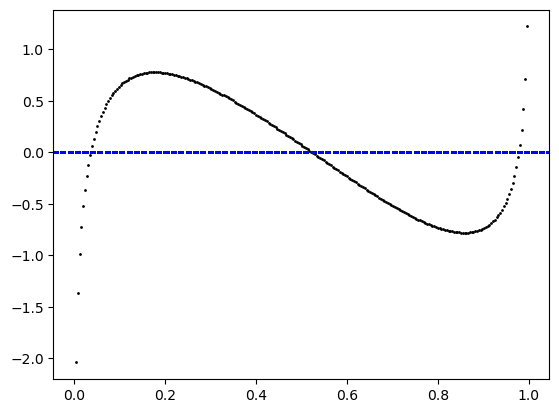

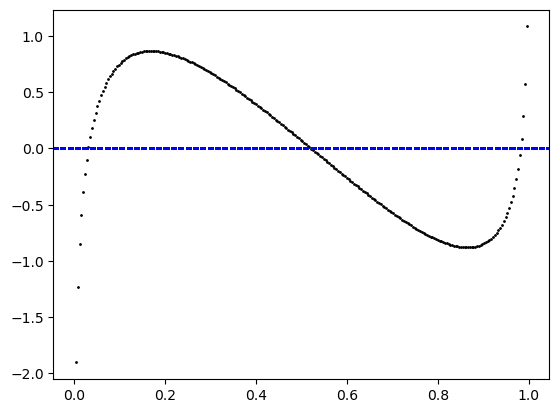

In [18]:
for chi in tqdm(chis[::10]):
    first_derivative = nd.Derivative(lambda phi: floryHuggins_2components(phi, nu, nA, nB, chi), n=1)
    df_dphis_chi = [] # values of delF/delphi for all phis for a particular chi

    fig, ax = plt.subplots()
    
    for idx, phi in enumerate(phis):
        df_dphi_phi = first_derivative(phi) # value of delF/delphi for a particular phi for a particular chi
        df_dphis_chi.append(df_dphi_phi)    
        ax.scatter(phi, df_dphi_phi, color = "k", s = 1)        
        ax.axhline(0, color = "blue", linestyle = "--", linewidth=1)
        